In [13]:
import numpy as np
import netCDF4 as nc
#!ls zLatent_*.nc
#!pwd
with nc.Dataset('zLatent_CONUSp.nc') as f:
    zKuSimL_kwaj=f['zKuSim'][:,:]
    sfcPrecipL_kwaj=f['sfcPrecip'][:]
    piaKuL_kwaj=f['piaKu'][:]

with nc.Dataset('zLatent_KWAJp.nc') as f:
    zKuSimL_conus=f['zKuSim'][:,:]
    sfcPrecipL_conus=f['sfcPrecip'][:]
    piaKuL_conus=f['piaKu'][:]

# concatenate the two datasets
zKuSimL=np.concatenate((zKuSimL_kwaj,zKuSimL_conus),axis=0)
#zWSimL=np.concatenate((zWSimL_kwaj,zWSimL_conus),axis=0)
sfcPrecipL=np.concatenate((sfcPrecipL_kwaj,sfcPrecipL_conus),axis=0)
piaKuL=np.concatenate((piaKuL_kwaj,piaKuL_conus),axis=0)

zKuSimL=np.array(zKuSimL)
zKuSimL[zKuSimL<12]=0
piaKuL=np.array(piaKuL)
print(zKuSimL.shape)
sfcPrecipL[sfcPrecipL<0]=0

(39582, 5, 24)


In [65]:
import numpy as np
zKun=np.array(zKuSimL)+np.random.randn(len(zKuSimL),5,24)*1.0
zKun=(zKun-20)/10.
piaKun=np.array(piaKuL)+np.random.randn(len(piaKuL),5)*1.0
yL=np.array(sfcPrecipL[:])
from sklearn.model_selection import train_test_split

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(zKun[:,:,:,np.newaxis], piaKun[:,:,np.newaxis,np.newaxis],  yL, test_size=0.25, random_state=42)

In [40]:
print(x1_train.shape)
print(x2_train.shape)
print(y_train.shape)

(29686, 5, 24, 1)
(29686, 5, 1, 1)
(29686, 5)


In [68]:
from uNet1D import unet1D, tbMLP

# define a 1D unet model with input size (24,6)
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, UpSampling1D, Dense , Conv2D, MaxPooling2D, Flatten  
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy


nx1,nz1=5,24
nx1,nz2=5,1
nn=32
def cnn_atrack_model():
    x1=Input(shape=(nx1,nz1,1))
    x2=Input(shape=(nx1,nz2,1))
    layer1=Conv2D(nn, kernel_size=(1, 2), activation='relu',padding='same')(x1)
    layer1=MaxPooling2D(pool_size=(1, 2))(layer1)
    layer2=Conv2D(nn*2, kernel_size=(1, 2), activation='relu',padding='same')(layer1)
    layer2=MaxPooling2D(pool_size=(1, 2))(layer2)
    layer3=Conv2D(nn, kernel_size=(1, 2), activation='relu',padding='same')(layer2)
    layer3=MaxPooling2D(pool_size=(1, 2))(layer3)
    layer3=Conv2D(nn/2, kernel_size=(1, 2), activation='relu',padding='same')(layer3)
    layer3=MaxPooling2D(pool_size=(1, 2))(layer3)
    layer3=Dropout(0.1)(layer3)
    layer=concatenate([layer3,x2],axis=-1)
    layer4=Conv2D(nn, kernel_size=(2, 1), activation='relu',padding='same')(layer)
    layer4=MaxPooling2D(pool_size=(2, 1))(layer4)
    layer5=Conv2D(nn, kernel_size=(2, 1), activation='relu')(layer4)
    layer5=Dropout(0.1)(layer5)
    layer6=Flatten()(layer5)
    output=Dense(nx1,activation='linear')(layer6)
    model1=tf.keras.Model(inputs=[x1,x2],outputs=output)
    return model1

test_model=cnn_atrack_model()
print(test_model.summary())
print(sfcPrecipL.min())


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 5, 24, 1)]           0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 5, 24, 32)            96        ['input_13[0][0]']            
                                                                                                  
 max_pooling2d_30 (MaxPooli  (None, 5, 12, 32)            0         ['conv2d_36[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 5, 12, 64)            4160      ['max_pooling2d_30[0][0]

In [69]:
test_model.compile(optimizer='adam', loss='mae', metrics=['mae'])
print(y_test.min())

0.0


In [72]:
out=test_model.predict([x1_train,x2_train])
hist=test_model.fit([x1_train,x2_train],np.log(1+y_train/1),epochs=15,batch_size=32,validation_data=([x1_test,x2_test],np.log(1+y_test/1)),verbose=1)

928/928 [==============================] - 1s 850us/step
Epoch 1/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3478 - mae: 0.3478 - val_loss: 0.3442 - val_mae: 0.3442
Epoch 2/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3482 - mae: 0.3482 - val_loss: 0.3472 - val_mae: 0.3472
Epoch 3/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3483 - mae: 0.3483 - val_loss: 0.3467 - val_mae: 0.3467
Epoch 4/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3474 - mae: 0.3474 - val_loss: 0.3467 - val_mae: 0.3467
Epoch 5/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3462 - mae: 0.3462 - val_loss: 0.3434 - val_mae: 0.3434
Epoch 6/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3463 - mae: 0.3463 - val_loss: 0.3445 - val_mae: 0.3445
Epoch 7/15
928/928 [==============================] - 3s 3ms/step - loss: 0.3464 - mae: 0.3464 - val_loss: 0.3456 - val_mae: 0.3456
Epoch 8/15
928/928 

In [47]:
print(out.shape)

(29686, 5)


310/310 [==============================] - 0s 843us/step
(9896, 5)
(9896, 5)
[0.5969072319781922, 0.10462511265020444, -0.0729025479244475, -0.16465014055627228]
[1.039151826030138, 0.5238805194864745, 0.4677836340725281, 0.44351472894708854]


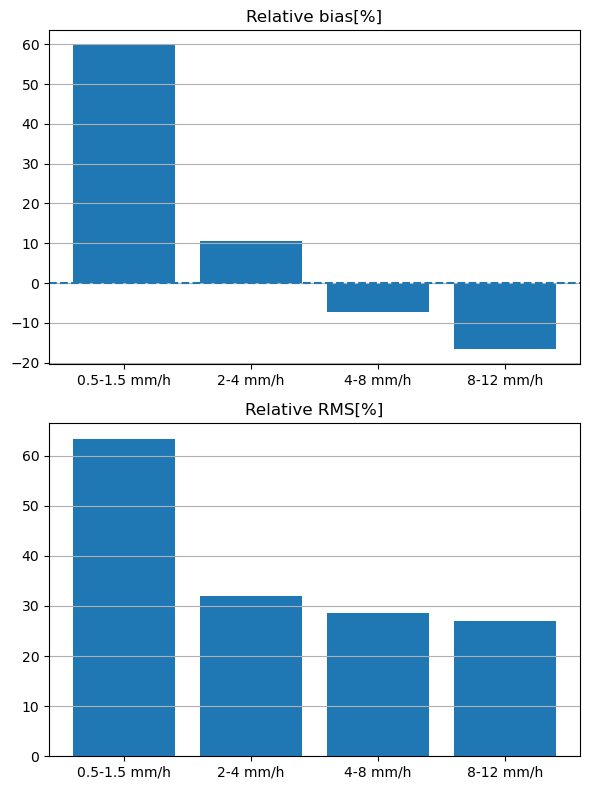

In [73]:
import matplotlib.pyplot as plt
y_predLGBM=1*(np.exp(test_model.predict([x1_test[:,:,:],x2_test[:,:,:]])[:,:])-1)
print(y_predLGBM.shape)
#y_predLGBM=lgbReg.predict(xknn_test)
evalInt=[[0.75,1.25],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
print(y_predLGBM.shape)
y_predLGBMm=y_predLGBM.mean(axis=1)
y_testm=y_test.mean(axis=1)
for int1 in evalInt:
    a=np.nonzero((y_testm>=int1[0]) & (y_testm<int1[1]))
    bias=np.mean(y_predLGBMm[a]-y_testm[a])/np.mean(y_testm[a])
    rms=np.sqrt(np.mean((y_predLGBMm[a]-y_testm[a])**2))/np.mean(y_testm[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0.5-1.5 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100*0.61)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('inclinedPrecipScoresKuCONUS_KWAJ_Along.png')

print(biasL)
print(rmsL)